100%|██████████| 600/600 [00:02<00:00, 249.12it/s]


=== Path points ===
Point 0: x=-1.0000, y=1.0000
Point 1: x=-0.7500, y=0.7525
Point 2: x=-0.5000, y=0.5066
Point 3: x=-0.2500, y=0.2575
Point 4: x=0.0000, y=0.0108
Point 5: x=0.0000, y=0.0000
Point 6: x=0.2500, y=-0.4611
Point 7: x=0.5000, y=-0.6409
Point 8: x=0.7500, y=-0.8201
Point 9: x=1.0000, y=-1.0000
Point 10: x=1.0000, y=-1.0000

Snell validation:
Incident angle θ1  = 45.380°
Refracted angle θ2 = 28.466°
n1*sinθ1 = 0.711781
n2*sinθ2 = 0.714945

Segment lengths:
Segment 0-1: 0.3518
Segment 1-2: 0.3506
Segment 2-3: 0.3529
Segment 3-4: 0.3512
Segment 4-5: 0.0108
Segment 5-6: 0.5245
Segment 6-7: 0.3080
Segment 7-8: 0.3076
Segment 8-9: 0.3080
Segment 9-10: 0.0000


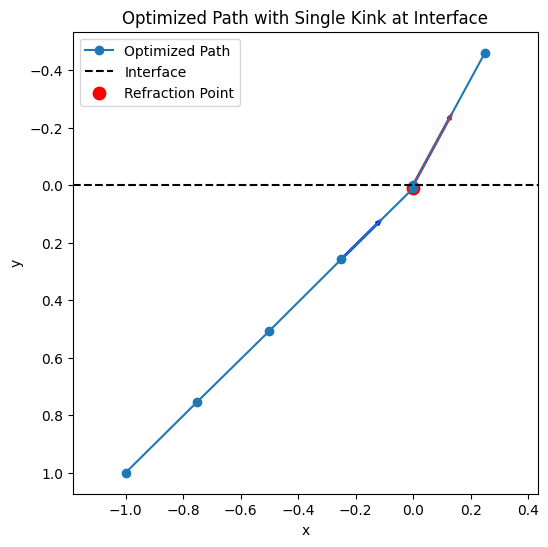

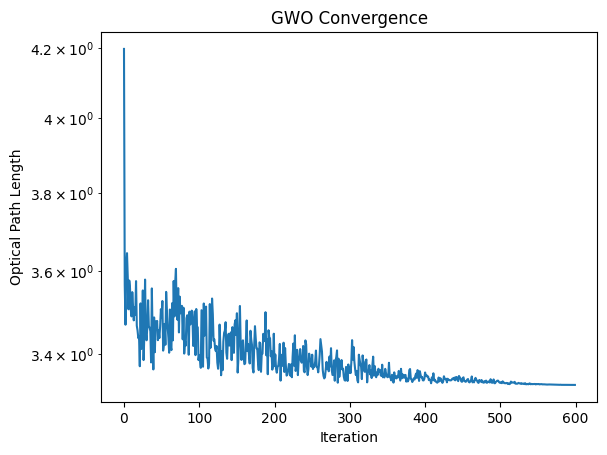

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from GWO.GWO_optimizer import GWOOptimizer  # your existing GWO implementation

# -----------------------------
# PHYSICAL PARAMETERS
# -----------------------------
n1 = 1.0          # refractive index above interface
n2 = 1.5          # refractive index below interface
y_interface = 0.0

A = np.array([-1.0, 1.0])   # source
B = np.array([1.0, -1.0])   # destination

num_points_above = 4
num_points_below = 4

population = 40
iterations = 600
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# X COORDINATES
# -----------------------------
x_interface_fixed = 0.0  # fixed interface
x_values_above = np.linspace(A[0], x_interface_fixed, num_points_above+1)[1:]
x_values_below = np.linspace(x_interface_fixed, B[0], num_points_below+1)[1:]

# -----------------------------
# REFRACTIVE INDEX FUNCTION
# -----------------------------
def refractive_index(p):
    return n1 if p[1] >= y_interface else n2

# -----------------------------
# OBJECTIVE FUNCTION
# -----------------------------
def optical_path_fixed_interface(y_coords):
    """
    y_coords: tensor of length (num_points_above + num_points_below)
    """
    y_above = y_coords[:num_points_above]
    y_below = y_coords[num_points_above:]

    pts = [torch.tensor(A, device=device)]
    # Points above
    for xi, yi in zip(x_values_above, y_above):
        pts.append(torch.tensor([xi, yi], device=device))
    # Fixed interface
    pts.append(torch.tensor([x_interface_fixed, y_interface], device=device))
    # Points below
    for xi, yi in zip(x_values_below, y_below):
        pts.append(torch.tensor([xi, yi], device=device))
    # End point
    pts.append(torch.tensor(B, device=device))

    # Optical path length
    cost = 0.0
    for i in range(len(pts)-1):
        cost += refractive_index(pts[i]) * torch.norm(pts[i+1] - pts[i])
    return cost

# -----------------------------
# BOUNDS
# -----------------------------
bounds_above = [(y_interface + 0.01, A[1])] * num_points_above
min_y_below = y_interface - 0.9  # minimum distance below interface
bounds_below = [(B[1], y_interface - 0.01)] * num_points_below  # keep below interface
bounds = bounds_above + bounds_below

# -----------------------------
# INITIAL GUESS
# -----------------------------
y_init_above = np.linspace(A[1], y_interface + 0.01, num_points_above)
y_init_below = np.linspace(y_interface - 0.01, B[1], num_points_below)
initial_guess = torch.tensor(np.concatenate([y_init_above, y_init_below]),
                             dtype=torch.float32, device=device)

# -----------------------------
# RUN GWO OPTIMIZER
# -----------------------------
optimizer = GWOOptimizer(
    objective_function=optical_path_fixed_interface,
    bounds=bounds,
    population_size=population,
    max_iter=iterations,
    device=device
)

best_solution, loss_curve = optimizer.optimize()

# -----------------------------
# RECONSTRUCT FULL PATH
# -----------------------------
y_above = best_solution[:num_points_above]
y_below = best_solution[num_points_above:]

pts = [A]
for xi, yi in zip(x_values_above, y_above):
    pts.append([xi, yi.item()])
pts.append([x_interface_fixed, y_interface])
for xi, yi in zip(x_values_below, y_below):
    pts.append([xi, yi.item()])
pts.append(B)
pts = np.array(pts)

# -----------------------------
# DEBUGGING OUTPUT
# -----------------------------
print("\n=== Path points ===")
for i, p in enumerate(pts):
    print(f"Point {i}: x={p[0]:.4f}, y={p[1]:.4f}")

# Exact interface crossing
p_above = pts[num_points_above]
p_below = pts[num_points_above+1]
v_incident = np.array([p_above[0]-pts[num_points_above-1][0], p_above[1]-pts[num_points_above-1][1]])
v_refracted = np.array([pts[num_points_above+2][0]-p_below[0], pts[num_points_above+2][1]-p_below[1]])

normal = np.array([0.0, 1.0])
def angle_with_normal(v):
    return np.degrees(np.arccos(np.clip(abs(np.dot(v, normal))/np.linalg.norm(v), 0.0, 1.0)))

theta1 = angle_with_normal(v_incident)
theta2 = angle_with_normal(v_refracted)

print("\nSnell validation:")
print(f"Incident angle θ1  = {theta1:.3f}°")
print(f"Refracted angle θ2 = {theta2:.3f}°")
print(f"n1*sinθ1 = {n1*np.sin(np.radians(theta1)):.6f}")
print(f"n2*sinθ2 = {n2*np.sin(np.radians(theta2)):.6f}")

# Segment lengths
segment_lengths = [np.linalg.norm(pts[i+1]-pts[i]) for i in range(len(pts)-1)]
print("\nSegment lengths:")
for i, l in enumerate(segment_lengths):
    print(f"Segment {i}-{i+1}: {l:.4f}")

# -----------------------------
# PLOT PATH
# -----------------------------
plt.figure(figsize=(6,6))
plt.plot(pts[:-4,0], pts[:-4,1], "-o", label="Optimized Path")
plt.axhline(y_interface, linestyle="--", color="black", label="Interface")
plt.scatter(p_above[0], p_above[1], c="red", s=80, label="Refraction Point")

plt.arrow(pts[num_points_above-1][0], pts[num_points_above-1][1],
          v_incident[0]*0.5, v_incident[1]*0.5,
          width=0.005, color='blue')
plt.arrow(p_below[0], p_below[1],
          v_refracted[0]*0.5, v_refracted[1]*0.5,
          width=0.005, color='red')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Optimized Path with Single Kink at Interface")
plt.legend()
plt.axis("equal")
plt.gca().invert_yaxis()
plt.show()

# -----------------------------
# CONVERGENCE PLOT
# -----------------------------
plt.figure()
plt.plot(loss_curve)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Optical Path Length")
plt.title("GWO Convergence")
plt.show()
